In [ ]:
!pip install nibabel

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib  # For reading NIfTI files

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Define the path to the participant data file in your Google Drive
participant_data_path = '/content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/participants.tsv'

# Load participant data
participant_data = pd.read_csv(participant_data_path, sep='\t')
participant_data['AgeClass'] = pd.cut(participant_data['Age'], bins=[3, 6, 13, np.inf], labels=['Ages3-5', 'Ages7-12', 'Adults'])

# Display the first few rows of the participant data
participant_data.head()


,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM Booklet-Matched,ToM Booklet-Matched-NOFB,FB_Composite,FB_Group,WPPSI BD raw,WPPSI BD scaled,KBIT_raw,KBIT_standard,DCCS Summary,Scanlog: Scanner,Scanlog: Coil,Scanlog: Voxel slize,Scanlog: Slice Gap,AgeClass
0,sub-pixar001,4.774812,4yo,child,M,R,0.80,0.736842,6.0,pass,22.0,13.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1,Ages3-5
1,sub-pixar002,4.856947,4yo,child,F,R,0.72,0.736842,4.0,inc,18.0,9.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.1,Ages3-5
2,sub-pixar003,4.153320,4yo,child,F,R,0.44,0.421053,3.0,inc,15.0,9.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1,Ages3-5
3,sub-pixar004,4.473648,4yo,child,F,R,0.64,0.736842,2.0,fail,17.0,10.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.2,Ages3-5
4,sub-pixar005,4.837782,4yo,child,F,R,0.60,0.578947,4.0,inc,13.0,5.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.2,Ages3-5


In [ ]:
# Step 3: List files in the directory to check for existence and correct naming

# Define the path to the MRI data folder in your Google Drive
mri_data_folder = '/content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data'

# List all files in the directory
for root, dirs, files in os.walk(mri_data_folder):
    for name in files:
        print(os.path.join(root, name))


/content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar080/sub-pixar080_normed_anat.nii.gz
/content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar080/sub-pixar080_analysis_mask.nii.gz
/content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar079/sub-pixar079_analysis_mask.nii.gz
/content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar079/sub-pixar079_normed_anat.nii.gz
/content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar078/sub-pixar078_normed_anat.nii.gz
/content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar078/sub-pixar078_a

In [ ]:
def load_2d_slices(mri_data_folder):
    images = []
    labels = []
    missing_files = []
    for participant_str in os.listdir(mri_data_folder):  # Iterate through all folders in the directory
        if participant_str.startswith('sub-pixar'):  # Check if the folder starts with 'sub-pixar'
            vol_path = os.path.join(mri_data_folder, participant_str, f'{participant_str}_normed_anat.nii.gz')
            print(f"Checking for file: {vol_path}")
            if not os.path.exists(vol_path):
                print(f"File not found: {vol_path}")
                missing_files.append(vol_path)
                continue
            vol = nib.load(vol_path).get_fdata()  # Read the NIfTI file using nibabel
            mid_slice = vol[:, :, vol.shape[2] // 2]
            images.append(mid_slice)
            labels.append(participant_data.loc[participant_data['participant_id'] == participant_str, 'AgeClass'].values[0])
    if missing_files:
        print(f"Missing files: {missing_files}")
    return np.array(images), np.array(labels)

# Step 5: Load and Preprocess the Data

# Define the path to the MRI data folder in your Google Drive
mri_data_folder = '/content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data'

# Load and preprocess the data
images, labels = load_2d_slices(mri_data_folder)
images = images[..., np.newaxis]  # Add channel dimension

Checking for file: /content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar080/sub-pixar080_normed_anat.nii.gz
Checking for file: /content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar079/sub-pixar079_normed_anat.nii.gz
Checking for file: /content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar078/sub-pixar078_normed_anat.nii.gz
Checking for file: /content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar077/sub-pixar077_normed_anat.nii.gz
Checking for file: /content/drive/MyDrive/Brain-MRI-Age-Classification-using-Deep-Learning/ds000228-1.1.0-subset/derivatives/preprocessed_data/sub-pixar076/sub-pixar076_normed_anat.nii.gz
Checking for file: /content/drive/MyDrive/Brain-MRI-Age-Clas

In [ ]:
# Encode labels as integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Step 6: Split the Data
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)

# Resize images to 224x224 and convert to 3 channels
def resize_and_convert(images):
    images_resized = []
    for img in images:
        img_resized = tf.image.resize(img, (224, 224))
        img_3ch = tf.image.grayscale_to_rgb(img_resized)  # Convert grayscale to RGB
        images_resized.append(img_3ch)
    return np.array(images_resized)

x_train_3ch = resize_and_convert(x_train)
x_test_3ch = resize_and_convert(x_test)


In [ ]:
# Step 7: Data Augmentation
datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)
train_gen = datagen.flow(x_train_3ch, y_train, batch_size=32, subset='training')
val_gen = datagen.flow(x_train_3ch, y_train, batch_size=32, subset='validation')

In [ ]:
# Step 8: Load and Prepare ResNet50 for Transfer Learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 9: Train the Model with Progress Bars
class CustomProgbar(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']}")
        for key, value in logs.items():
            print(f"{key}: {value:.4f}")

# Train the model
model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[CustomProgbar()])

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 3.5718 - accuracy: 0.6346Epoch 1/10
loss: 3.5718
accuracy: 0.6346
val_loss: 3.0643
val_accuracy: 0.9167
2/2 [==============================] - 5s 1s/step - loss: 3.5718 - accuracy: 0.6346 - val_loss: 3.0643 - val_accuracy: 0.9167
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 7.5516 - accuracy: 0.7885Epoch 2/10
loss: 7.5516
accuracy: 0.7885
val_loss: 2.0832
val_accuracy: 0.9167
2/2 [==============================] - 1s 404ms/step - loss: 7.5516 - accuracy: 0.7885 - val_loss: 2.0832 - val_accuracy: 0.9167
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 5.0993 - accuracy: 0.7885Epoch 3/10
loss: 5.0993
accuracy: 0.7885
val_loss: 0.8079
val_accuracy: 0.9167
2/2 [==============================] - 1s 407ms/step - loss: 5.0993 - accuracy: 0.7885 - val_loss: 0.8079 - val_accuracy: 0.9167
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 1.5432 - accuracy: 0.7885Epoch 4/10
loss

In [ ]:
# Step 10: Evaluate the Model
test_gen = datagen.flow(x_test_3ch, y_test, batch_size=32, shuffle=False)
y_pred = np.argmax(model.predict(test_gen), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy}')

1/1 [==============================] - 1s 1s/step
Test accuracy: 0.8125


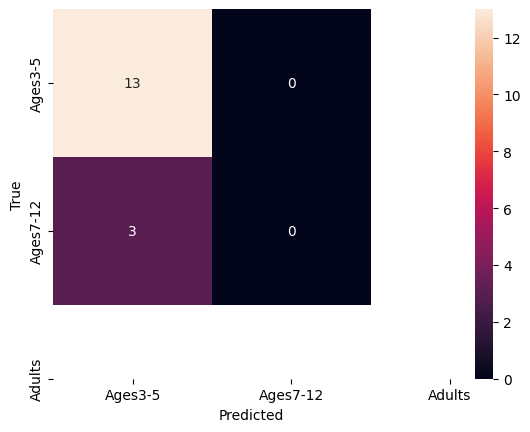

In [ ]:
# Step 11: Confusion Matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Ages3-5', 'Ages7-12', 'Adults'], yticklabels=['Ages3-5', 'Ages7-12', 'Adults'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 [==============================] - 0s 22ms/step


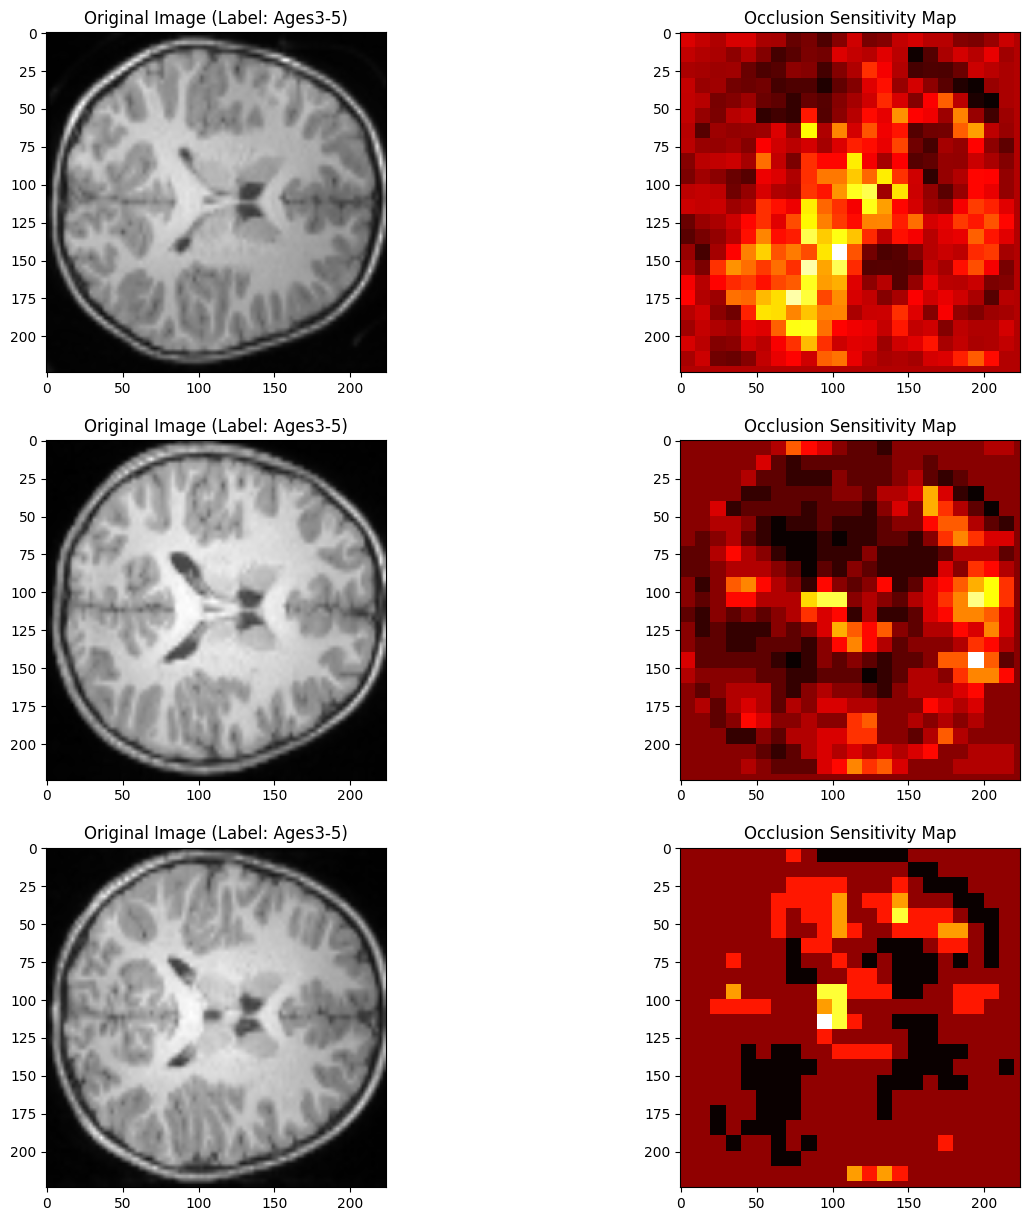

ValueError: y contains previously unseen labels: 'Ages6-8'

In [ ]:
# Step 11: Visualize Features Used by Network via Occlusion Sensitivity Maps
def compute_occlusion_sensitivity_map(model, image, label, patch_size=10):
    original_pred = model.predict(image[np.newaxis, ...])[0]
    sensitivity_map = np.zeros(image.shape[:2])
    for i in range(0, image.shape[0] - patch_size + 1, patch_size):
        for j in range(0, image.shape[1] - patch_size + 1, patch_size):
            occluded_image = image.copy()
            occluded_image[i:i+patch_size, j:j+patch_size, :] = 0
            occluded_pred = model.predict(occluded_image[np.newaxis, ...])[0]
            sensitivity_map[i:i+patch_size, j:j+patch_size] = original_pred[label] - occluded_pred[label]
    return sensitivity_map

def view_occlusion_sensitivity_maps(class_label, num_images, model, x_test, y_test, y_pred):
    class_index = np.where(y_test == class_label)[0]
    correctly_classified = class_index[y_test[class_index] == y_pred[class_index]]
    selected_indices = np.random.choice(correctly_classified, num_images, replace=False)

    plt.figure(figsize=(15, 5 * num_images))
    for idx, img_index in enumerate(selected_indices):
        image = x_test[img_index]
        label = y_test[img_index]
        sensitivity_map = compute_occlusion_sensitivity_map(model, image, label)

        plt.subplot(num_images, 2, 2*idx+1)
        plt.imshow(image / np.max(image))
        plt.title(f'Original Image (Label: {label_encoder.inverse_transform([label])[0]})')

        plt.subplot(num_images, 2, 2*idx+2)
        plt.imshow(sensitivity_map, cmap='hot', interpolation='nearest')
        plt.title('Occlusion Sensitivity Map')
    plt.show()

# Visualize for class "Ages3-5" with 3 random images
class_label = label_encoder.transform(['Ages3-5'])[0]
view_occlusion_sensitivity_maps(class_label, 3, model, x_test_3ch, y_test, y_pred)

# Visualize for other classes with 3 random images
for class_name in ['Ages6-8', 'Ages9-11']:
    class_label = label_encoder.transform([class_name])[0]
    view_occlusion_sensitivity_maps(class_label, 3, model, x_test_3ch, y_test, y_pred)